<a href="https://colab.research.google.com/github/DressPD/electric_motion_forecast/blob/main/data_analysis_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Schneider Electric Challenge**
---
*    Data Analytics for Application class
*    WiSe 22/23 - TUM
*    Prepared and developed by Aris Dressino, Giovanni Filomeno, Daniel Jaumann, Tobias Hudertmark

IMPORTANT in Google Colab: Go to Runtime>Change runtime type>Select GPU (not TPU) for faster executions

In [1]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [2]:
#set matplot size and random seeds
sns.set(rc={'figure.figsize':(24,10)})

In [3]:
# colab package for file reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# reading files from Google Drive
data_hor_disc = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/DiscreteMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
data_hor_cont = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/ContinuousMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
#data_ver_disc = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/DiscreteMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
#data_ver_cont = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/ContinuousMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
data_combined_hor = pd.read_csv('/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/combined_data_hor.csv')
data_combined_ver = pd.read_csv('/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/combined_data_ver.csv')
# use this in local environment
# data_hor_disc = pd.read_excel("path/", sheet_name="name")

## **exploratory data analysis and visualization**
---

1.   Summary statistics and head
2.   Visualization of continuous and discrete patterns per selected rotations per minute (RPM)
3. Fourier Transform of combined datasets

In [5]:
# head of discrete horizontal table
data_hor_disc.head(5)

,Pow_100,Pow_200,Pow_300,Pow_400,Pow_500,Pow_600,Pow_700,Pow_800,Pow_900,Pow_1000,Pow_1100,Pow_1200,Pow_1300,Pow_1400,Pow_1500,Pow_1600,Pow_1700,Pow_1800,Pow_1900,Pow_2000
0,0.846,0.044,0.014,0.255,4.009,0.516,5.616,7.860,9.240,9.974999,10.981999,6.578000,12.059999,7.950,12.599,9.990001,9.555000,19.096001,13.938000,0.202
1,0.846,0.044,0.167,0.255,4.009,0.516,5.616,7.860,9.240,9.974999,10.981999,6.578000,12.059999,7.950,12.599,9.990001,9.555000,19.096001,13.938000,0.202
2,0.846,0.044,0.167,0.255,4.009,5.676,5.400,6.930,9.240,9.974999,9.728000,6.578000,11.834999,7.830,12.599,9.990001,10.465000,13.454000,11.039999,0.564
3,0.774,0.147,0.167,4.080,4.199,5.676,5.400,6.930,7.854,8.014999,9.728000,6.578000,11.834999,7.830,7.267,9.287000,10.465000,13.454000,11.039999,0.564
4,0.774,0.147,2.171,4.080,4.199,5.676,5.400,6.468,7.854,8.014999,9.472000,10.372999,11.834999,12.267,7.267,9.287000,15.548001,13.454000,11.280000,10.434


In [6]:
# descriptive statistics of continuous horizontal table
data_hor_cont.describe()
# as expected, we register increasing mean and standard deviation along with increased RPM

,Pow_100,Pow_200,Pow_300,Pow_400,Pow_500,Pow_600,Pow_700,Pow_800,Pow_900,Pow_1000,Pow_1100,Pow_1200,Pow_1300,Pow_1400,Pow_1500,Pow_1600,Pow_1700,Pow_1800,Pow_1900,Pow_2000
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.914997,1.489418,2.085885,2.704043,3.316586,3.971865,4.581573,5.268829,5.965631,6.633125,7.357132,8.101215,8.847017,9.569282,10.302015,10.961324,11.728856,12.532663,13.285962,13.883382
std,0.115249,0.203847,0.334017,0.514336,0.724688,0.941374,1.204082,1.495026,1.817265,2.229889,2.616157,3.043377,3.524884,4.005067,4.572351,5.205278,5.829242,6.454288,7.140127,7.816016
min,0.000000,0.054000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.858000,1.422000,2.004000,2.610000,3.258000,3.948000,4.608000,5.346000,6.120000,6.962999,7.743999,8.502001,9.245000,9.917999,9.486000,8.320000,7.708000,7.134000,6.931000,6.480000
50%,0.900000,1.485000,2.100000,2.760000,3.420000,4.137000,4.824000,5.616000,6.450000,7.326000,8.288000,9.240000,10.248001,11.340000,12.495000,13.624001,15.007998,16.298000,17.732000,18.910000
75%,0.960000,1.575000,2.236000,2.925000,3.618000,4.347000,5.064000,5.908000,6.789001,7.718000,8.695000,9.760000,10.836000,11.914000,13.082999,14.310000,15.679999,17.109999,18.538000,19.997999
max,1.316000,1.960000,2.990000,4.335000,5.520000,6.648000,7.398000,8.460000,9.537000,10.512000,11.271000,12.474001,14.344000,15.745001,16.650000,17.712000,19.207998,20.940001,22.528000,23.517000


In [7]:
# descriptive statistics of discrete horizontal table
data_hor_disc.describe()

,Pow_100,Pow_200,Pow_300,Pow_400,Pow_500,Pow_600,Pow_700,Pow_800,Pow_900,Pow_1000,Pow_1100,Pow_1200,Pow_1300,Pow_1400,Pow_1500,Pow_1600,Pow_1700,Pow_1800,Pow_1900,Pow_2000
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.843142,1.249023,1.604354,1.951205,2.206332,2.493221,2.730921,2.848026,3.118614,3.295054,3.453644,3.577217,3.732571,3.902852,3.908951,4.052579,4.156900,4.182729,4.218840,4.217175
std,0.253721,0.579047,0.920542,1.298846,1.663406,2.058099,2.446147,2.785256,3.201309,3.574365,3.955490,4.300227,4.628946,5.014324,5.244952,5.600147,5.836061,5.949107,6.142617,6.150047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.834000,1.332000,0.531000,0.294000,0.264000,0.265500,0.264000,0.244000,0.258000,0.264000,0.264000,0.238000,0.234000,0.256000,0.243000,0.255000,0.273000,0.256000,0.255000,0.270000
50%,0.900000,1.458000,2.040000,2.625000,3.204000,3.738000,2.873000,1.220000,0.828000,0.735000,0.606000,0.516000,0.458000,0.417000,0.486000,0.434500,0.426000,0.405000,0.417000,0.447000
75%,0.960000,1.575000,2.210000,2.896000,3.553000,4.242000,4.950000,5.655000,6.498750,7.310000,8.103001,8.639999,8.649000,8.613000,7.670001,7.525000,7.524000,7.560000,7.232000,7.175000
max,1.316000,2.360000,3.528000,5.100000,6.380000,7.608000,9.099999,9.641000,10.642000,11.375999,12.558001,13.631000,14.899000,16.224001,17.237999,19.139999,20.235001,22.019999,23.808001,23.487999


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


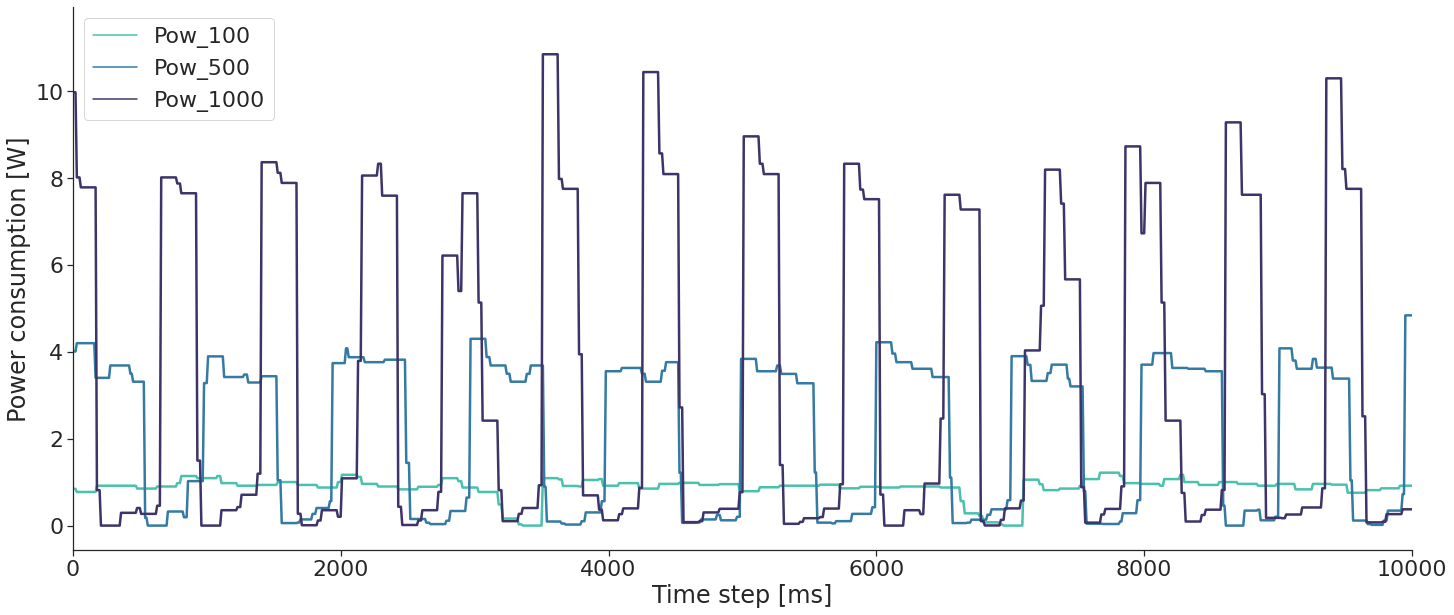

In [8]:
#line plot of selected discrete horizontal motors
#add timesteps in ms for discrete tables
data_hor_disc['time_steps'] = range(0, 10*len(data_hor_disc), 10)
#data_hor_disc.head(10)
#plot melted table for discrete values
#colors = ["#b5de2b", "#26828e", "#440154"]
sns.set(font_scale=2)
sns.set_style("white")
sns.set_style("ticks")
reference_pow=["Pow_100","Pow_500","Pow_1000"]
line_hor_disc = sns.lineplot("time_steps", "Watts", hue="Pow", hue_order=reference_pow,
             data=data_hor_disc.melt("time_steps", var_name="Pow", value_name="Watts"), linewidth=2.5, palette=sns.color_palette("mako_r", 3))
line_hor_disc.set_xlim(0,10000)
#line_hor_disc.set(title='Watts consumed per RPM in discrete motion')
line_hor_disc.set(xlabel='Time step [ms]', ylabel='Power consumption [W]')
line_hor_disc.legend(loc='upper left')
sns.despine()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


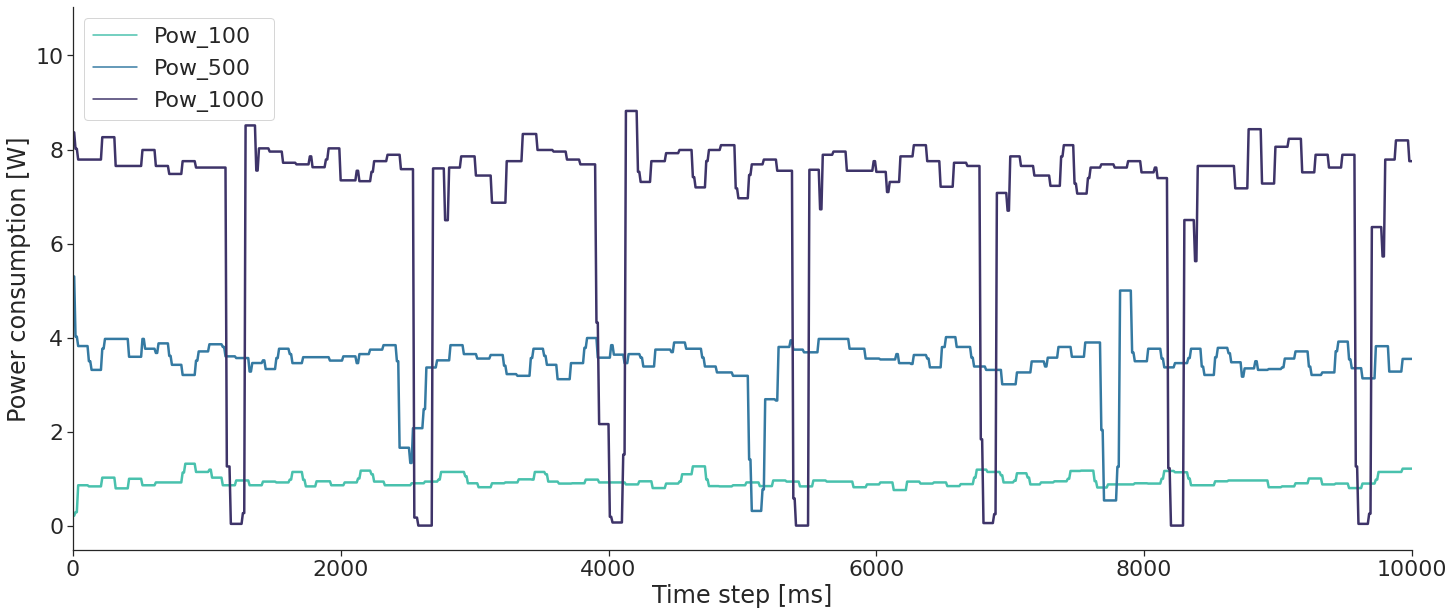

In [9]:
#line plot of selected continuous horizontal motors
#add timesteps in ms to continuous table
data_hor_cont['time_steps'] = range(0, 10*len(data_hor_cont), 10)
#data_hor_cont.head(10)
#plot melted table for continuous values

reference_pow=["Pow_100","Pow_500","Pow_1000"]
line_hor_cont = sns.lineplot("time_steps", "Watts", hue="Pow", hue_order=reference_pow,
             data=data_hor_cont.melt("time_steps", var_name="Pow", value_name="Watts"), linewidth=2.5, palette=sns.color_palette("mako_r", 3))

line_hor_cont.set_xlim(0,10000)
#line_hor_cont.set(title='Watts consumed per RPM in continuous motion')
line_hor_cont.set(xlabel='Time step [ms]', ylabel='Power consumption [W]')
line_hor_cont.legend(loc='upper left')
sns.despine()

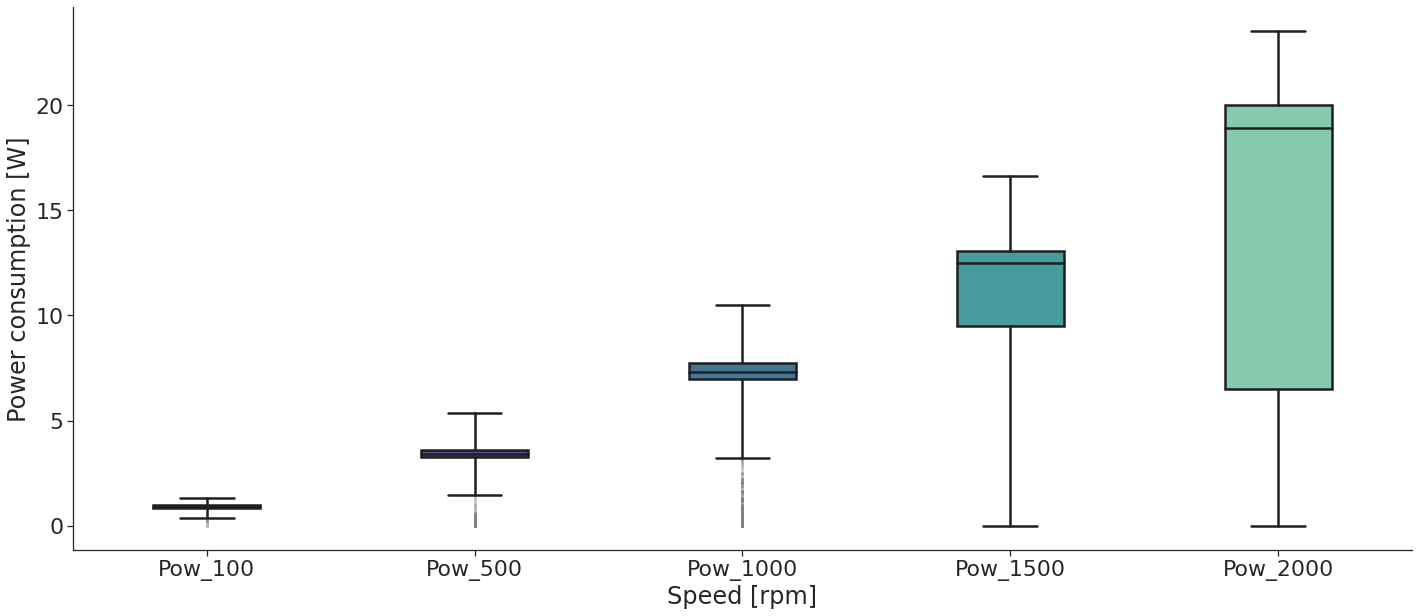

In [10]:
# boxplots of RPM distributions per selected continuous RPM categories
# increasing mean and variance are observable in our data
boxplot_data = data_hor_cont[["Pow_100", "Pow_500", "Pow_1000", "Pow_1500", "Pow_2000"]]
boxplot_data = boxplot_data.melt(var_name="Pow", value_name="Watts")
flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='grey', alpha=0.01)
bp = sns.boxplot(x="Pow", y="Watts", hue="Pow", width=0.4, whis=5, flierprops=flierprops, data=boxplot_data, linewidth=2.5, palette=sns.color_palette("mako", 5), dodge =False)
#bp.set(title='Distribution boxplots for RPM in continuous motion') 
bp.legend([],[], frameon=False)
bp.set(xlabel='Speed [rpm]', ylabel='Power consumption [W]')
sns.set(font_scale=2)
sns.set_style("white")
sns.set_style("ticks")
sns.despine()

[Text(0, 0.5, 'Range of Power Consumption'),
 Text(0.5, 0, 'Speed'),
 Text(0.5, 1.0, 'Statistical Range of Power Consumption over Speed')]

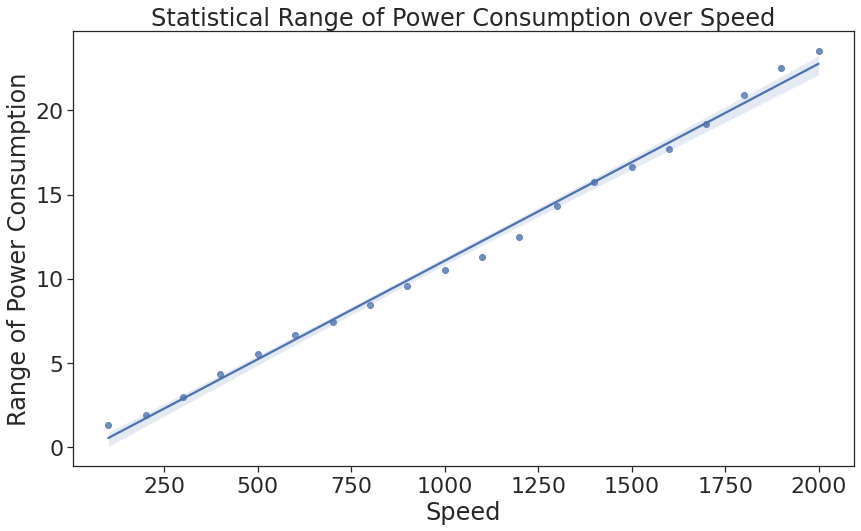

In [11]:
# statistical range of power consumption over speed
# drop time_steps columns
data_hor_disc.drop(columns=['time_steps'], inplace=True)
data_hor_cont.drop(columns=['time_steps'], inplace=True)

# list of horizontal continuous columns
columns_hor_cont = list(data_hor_cont.columns)
speeds_hor_cont = []
for speed in columns_hor_cont:
  speed = int(speed[4:])
  speeds_hor_cont.append(speed)
# print(speeds_hor_cont)

range_hor_cont = []
for label, content in data_hor_cont.items():
  range_hor_cont.append(abs(content.max() - content.min()))
# print(range_hor_cont)

sns.set(rc={'figure.figsize':(14,8)})
sns.set(font_scale=2)
sns.set_style("white")
sns.set_style("ticks")
sns.regplot(x=speeds_hor_cont, y=range_hor_cont).set(xlabel="Speed", ylabel="Range of Power Consumption", title="Statistical Range of Power Consumption over Speed")

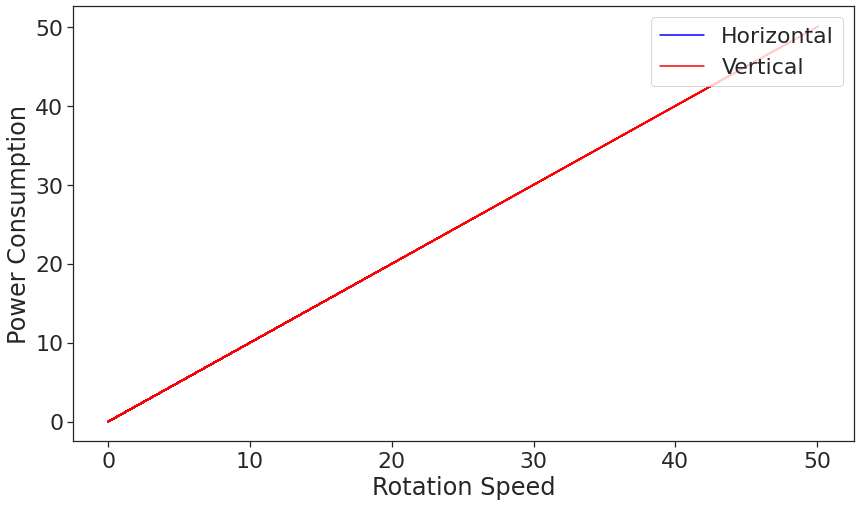

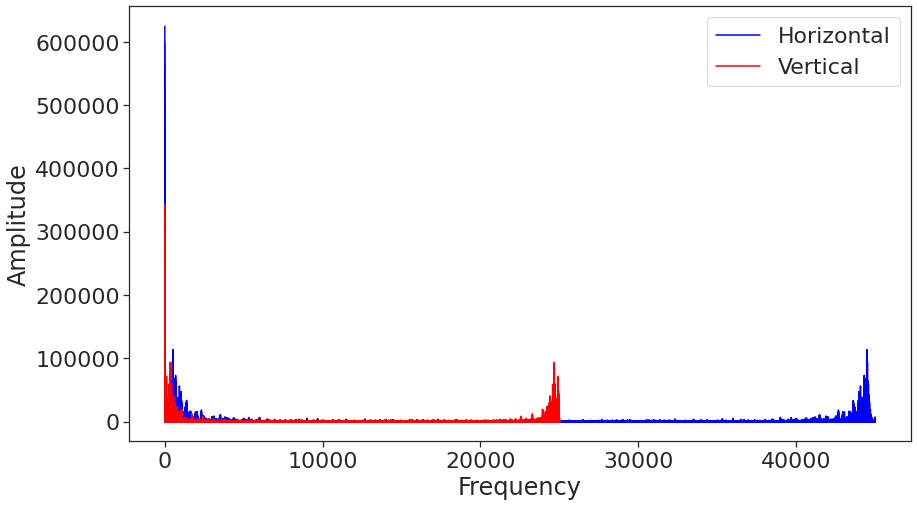

In [14]:
from scipy.fft import fft
# Plot the power consumption for each column in both datasets
for col in data_combined_hor.columns:
    if col.startswith("Pow"):
        plt.plot(data_combined_hor[col], data_combined_hor[col], label="Horizontal", color='blue')
for col in data_combined_ver.columns:
    if col.startswith("Power"):
        plt.plot(data_combined_ver[col], data_combined_ver[col], label="Vertical", color='red')
plt.xlabel("Rotation Speed")
plt.ylabel("Power Consumption")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")
plt.show()

# Perform a Fourier transform on the data
for col in data_combined_hor.columns:
    if col.startswith("Pow"):
        horizontal_fft = np.abs(fft(data_combined_hor[col].to_numpy()))
        plt.plot(horizontal_fft, label="Horizontal", color='blue')
for col in data_combined_ver.columns:
    if col.startswith("Power"):
        vertical_fft = np.abs(fft(data_combined_ver[col].to_numpy()))
        plt.plot(vertical_fft, label="Vertical", color='red')
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")
# plt.legend()
plt.show()

## **data preparation** for LSTM model
- performed on continuous horizontal data
---

In [ ]:
#continuous data are used
from sklearn.preprocessing import MinMaxScaler
#data_hor_combined.drop(columns=['Unnamed: 0'], inplace=True)
power_list = [i for i in data_hor_cont.columns]
scaler = MinMaxScaler()

#change length for selected dataset
length = len(data_hor_cont)
perc_train=0.6
perc_test=0.2

#Splitting the dataset into train and test --> 60% in length is used for train
#60% in length is used for train, 20% for validation and 20% for test
#validation is used to avoid test overfitting
train_size = int(length * perc_train)
test_size = int(length * perc_test)
df_train = data_hor_cont[0:train_size]
df_valid = data_hor_cont[train_size:(train_size+test_size)]
df_test = data_hor_cont[(train_size+test_size):length]

scaled_train = scaler.fit_transform(df_train[power_list])
scaled_valid = scaler.fit_transform(df_valid[power_list])
scaled_test = scaler.transform(df_test[power_list])

#control nan in scaled datasets
print(np.isnan(scaled_train.max()))
print(np.isnan(scaled_test.max()))

False
False


In [ ]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [ ]:
#function to evaluate forecast with test values and provide mae/mse/mape of the predictions
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [ ]:
LOOK_BACK=500
FORECAST_RANGE=20
n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_valid, y_valid = split_sequence(scaled_valid, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(26481, 500, 20)
(26481, 20, 20)
(8481, 500, 20)
(8481, 20, 20)
(8481, 500, 20)
(8481, 20, 20)


In [ ]:
#reshape matrices with inverse transform
def inverse_transform(y_test, yhat):
  y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
  yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
  yhat_inverse = scaler.inverse_transform(yhat_reshaped)
  y_test_inverse = scaler.inverse_transform(y_test_reshaped)
  return yhat_inverse, y_test_inverse

## Series **models fitting**
---
- tangent ('tanh') function is used as activation function for LSTM layers for faster convergence and lower computational cost
- various trained models fit on continuous horizonatal data validation set




In [ ]:
epochs = 20
batch_size = 32
validation = 0.1

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Schneider_Electric/improvementsModel_20/weights-improvement-{epoch:04d}-{val_loss:.6f}.hdf5'
#"/content/drive/MyDrive/Schneider_Electric/improvementsModel/..."
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.005)

In [ ]:
## basic Encoder - Decoder Model
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='tanh', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_valid, verbose=0)
yhat_inverse, y_valid_inverse = inverse_transform(y_valid, yhat)
evaluate_forecast(y_valid_inverse, yhat_inverse)

Epoch 1/20
745/745 [==============================] - 25s 23ms/step - loss: 0.0479 - val_loss: 0.0360 - lr: 0.0010
Epoch 2/20
745/745 [==============================] - 16s 22ms/step - loss: 0.0289 - val_loss: 0.0287 - lr: 0.0010
Epoch 3/20
745/745 [==============================] - 16s 21ms/step - loss: 0.0237 - val_loss: 0.0263 - lr: 0.0010
Epoch 4/20
745/745 [==============================] - 16s 21ms/step - loss: 0.0210 - val_loss: 0.0251 - lr: 0.0010
Epoch 5/20
745/745 [==============================] - 18s 24ms/step - loss: 0.0187 - val_loss: 0.0237 - lr: 0.0010
Epoch 6/20
745/745 [==============================] - 18s 25ms/step - loss: 0.0171 - val_loss: 0.0243 - lr: 0.0010
Epoch 7/20
745/745 [==============================] - 17s 22ms/step - loss: 0.0157 - val_loss: 0.0234 - lr: 0.0010
Epoch 8/20
745/745 [==============================] - 18s 25ms/step - loss: 0.0146 - val_loss: 0.0224 - lr: 0.0010
Epoch 9/20
745/745 [==============================] - 18s 24ms/step - loss: 0.01

In [ ]:
## CNN-LSTM Encoder - Decoder Model

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation='tanh', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

plot_model(model=model_enc_dec_cnn, show_shapes=True)
history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec_cnn.predict(X_valid, verbose=0)
yhat_inverse, y_valid_inverse = inverse_transform(y_valid, yhat)
evaluate_forecast(y_valid_inverse, yhat_inverse)

Epoch 1/20
745/745 [==============================] - 25s 27ms/step - loss: 0.0279 - val_loss: 0.0198 - lr: 0.0010
Epoch 2/20
745/745 [==============================] - 21s 28ms/step - loss: 0.0142 - val_loss: 0.0182 - lr: 0.0010
Epoch 3/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0108 - val_loss: 0.0177 - lr: 0.0010
Epoch 4/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0088 - val_loss: 0.0179 - lr: 0.0010
Epoch 5/20
745/745 [==============================] - 20s 26ms/step - loss: 0.0075 - val_loss: 0.0181 - lr: 0.0010
Epoch 6/20
745/745 [==============================] - 20s 26ms/step - loss: 0.0067 - val_loss: 0.0180 - lr: 0.0010
Epoch 7/20
745/745 [==============================] - 19s 26ms/step - loss: 0.0061 - val_loss: 0.0180 - lr: 0.0010
Epoch 8/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0055 - val_loss: 0.0179 - lr: 0.0010
Epoch 9/20
745/745 [==============================] - 20s 27ms/step - loss: 0.00

In [ ]:
## Vector Output Model

input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='relu')(conv)
lstm = LSTM(100, return_sequences=True, activation='tanh')(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100, activation='tanh')(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='relu')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

plot_model(model=model_vector_output, show_shapes=True)
history = model_vector_output.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_vector_output.predict(X_valid, verbose=0)
yhat_inverse, y_valid_inverse = inverse_transform(y_valid, yhat)
evaluate_forecast(y_valid_inverse, yhat_inverse)

Epoch 1/20
745/745 [==============================] - 32s 39ms/step - loss: 0.1350 - val_loss: 0.1143 - lr: 0.0010
Epoch 2/20
745/745 [==============================] - 27s 37ms/step - loss: 0.1017 - val_loss: 0.1001 - lr: 0.0010
Epoch 3/20
745/745 [==============================] - 28s 37ms/step - loss: 0.0926 - val_loss: 0.0844 - lr: 0.0010
Epoch 4/20
745/745 [==============================] - 27s 37ms/step - loss: 0.0737 - val_loss: 0.0701 - lr: 0.0010
Epoch 5/20
745/745 [==============================] - 28s 37ms/step - loss: 0.0599 - val_loss: 0.0573 - lr: 0.0010
Epoch 6/20
745/745 [==============================] - 27s 37ms/step - loss: 0.0468 - val_loss: 0.0503 - lr: 0.0010
Epoch 7/20
745/745 [==============================] - 28s 38ms/step - loss: 0.0398 - val_loss: 0.0458 - lr: 0.0010
Epoch 8/20
745/745 [==============================] - 27s 37ms/step - loss: 0.0321 - val_loss: 0.0433 - lr: 0.0010
Epoch 9/20
745/745 [==============================] - 28s 37ms/step - loss: 0.02

In [ ]:
#Multi-Head CNN-LSTM Model -> loop for features

input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
 conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
 conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
 conv_layer_flatten = Flatten()(conv_layer_head_2)
 head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='tanh')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='tanh', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation="linear")(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mean_squared_error', optimizer='adam')

plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = multi_head_cnn_lstm_model.predict(X_valid, verbose=0)
yhat_inverse, y_valid_inverse = inverse_transform(y_valid, yhat)
evaluate_forecast(y_valid_inverse, yhat_inverse)


Epoch 1/20
745/745 [==============================] - 94s 111ms/step - loss: 0.0583 - val_loss: 0.0474 - lr: 0.0010
Epoch 2/20
745/745 [==============================] - 81s 109ms/step - loss: 0.0463 - val_loss: 0.0436 - lr: 0.0010
Epoch 3/20
745/745 [==============================] - 84s 113ms/step - loss: 0.0420 - val_loss: 0.0416 - lr: 0.0010
Epoch 4/20
745/745 [==============================] - 80s 108ms/step - loss: 0.0400 - val_loss: 0.0402 - lr: 0.0010
Epoch 5/20
745/745 [==============================] - 80s 108ms/step - loss: 0.0377 - val_loss: 0.0385 - lr: 0.0010
Epoch 6/20
745/745 [==============================] - 81s 109ms/step - loss: 0.0356 - val_loss: 0.0376 - lr: 0.0010
Epoch 7/20
745/745 [==============================] - 82s 110ms/step - loss: 0.0339 - val_loss: 0.0385 - lr: 0.0010
Epoch 8/20
745/745 [==============================] - 81s 109ms/step - loss: 0.0439 - val_loss: 0.0422 - lr: 0.0010
Epoch 9/20
745/745 [==============================] - 81s 108ms/step - l

## **evaluation** of model metrics and precision
---
- best performing model fitted on continuos test set

In [ ]:
## we now fit the test set on the best performing model
## CNN-LSTM Encoder - Decoder Model

plot_model(model=model_enc_dec_cnn, show_shapes=True)
history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec_cnn.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

Epoch 1/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0042 - val_loss: 0.0183 - lr: 0.0010
Epoch 2/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0040 - val_loss: 0.0183 - lr: 0.0010
Epoch 3/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0038 - val_loss: 0.0182 - lr: 0.0010
Epoch 4/20
745/745 [==============================] - 19s 26ms/step - loss: 0.0037 - val_loss: 0.0186 - lr: 0.0010
Epoch 5/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0036 - val_loss: 0.0184 - lr: 0.0010
Epoch 6/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0034 - val_loss: 0.0188 - lr: 0.0010
Epoch 7/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0033 - val_loss: 0.0183 - lr: 0.0010
Epoch 8/20
745/745 [==============================] - 20s 27ms/step - loss: 0.0032 - val_loss: 0.0187 - lr: 0.0010
Epoch 9/20
745/745 [==============================] - 20s 26ms/step - loss: 0.00